In [97]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms.community import girvan_newman
import itertools


In [98]:
P_same=0.5
P_other = 0.02

In [99]:
# Task 1 & 2: Community Detection Methods and Parameter Sweep
# Import additional community detection methods
from networkx.algorithms.community import greedy_modularity_communities, label_propagation_communities, asyn_lpa_communities
from sklearn.metrics import adjusted_rand_score
from itertools import combinations
import pandas as pd

def jaccard_index_corrected(true_communities, detected_communities):
    """Calculate Jaccard Index by comparing pairs of nodes"""
    # Create node-to-community mappings
    true_labels = {}
    detected_labels = {}
    
    for i, community in enumerate(true_communities):
        for node in community:
            true_labels[node] = i
    
    for i, community in enumerate(detected_communities):
        for node in community:
            detected_labels[node] = i
    
    # Get all nodes
    all_nodes = set(true_labels.keys()) | set(detected_labels.keys())
    
    # Count pairs
    a = 0  # Same community in both
    b = 0  # Same in true, different in detected
    c = 0  # Different in true, same in detected
    
    for node1, node2 in combinations(all_nodes, 2):
        true_same = (true_labels.get(node1, -1) == true_labels.get(node2, -1))
        detected_same = (detected_labels.get(node1, -1) == detected_labels.get(node2, -1))
        
        if true_same and detected_same:
            a += 1
        elif true_same and not detected_same:
            b += 1
        elif not true_same and detected_same:
            c += 1
    
    return a / (a + b + c) if (a + b + c) > 0 else 0


def calculate_metrics_sklearn(true_communities, detected_communities):
    """Calculate metrics using sklearn (more reliable)"""
    # Create label arrays
    all_nodes = sorted(set().union(*true_communities, *detected_communities))
    
    true_labels = np.zeros(len(all_nodes))
    detected_labels = np.zeros(len(all_nodes))
    
    for i, community in enumerate(true_communities):
        for node in community:
            if node in all_nodes:
                true_labels[all_nodes.index(node)] = i
    
    for i, community in enumerate(detected_communities):
        for node in community:
            if node in all_nodes:
                detected_labels[all_nodes.index(node)] = i
    
    # Calculate Adjusted Rand Index
    ari = adjusted_rand_score(true_labels, detected_labels)
    
    # Calculate Jaccard Index manually
    jaccard = jaccard_index_corrected(true_communities, detected_communities)
    
    return ari, jaccard

def communities_to_sets(communities):
    """Convert community list to set of tuples for comparison"""
    return set(tuple(sorted(community)) for community in communities)

def apply_community_methods(G):
    """Apply 4 different community detection methods to a graph"""
    methods = {}
    
    # 1. Girvan-Newman
    try:
        gn_generator = girvan_newman(G)
        gn_communities = [list(community) for community in next(gn_generator)]
        methods['Girvan-Newman'] = gn_communities
    except:
        methods['Girvan-Newman'] = [list(G.nodes())]
    
    # 2. Greedy Modularity
    try:
        gm_communities = list(greedy_modularity_communities(G))
        methods['Greedy Modularity'] = gm_communities
    except:
        methods['Greedy Modularity'] = [list(G.nodes())]
    
    # 3. Label Propagation
    try:
        lp_communities = list(label_propagation_communities(G))
        methods['Label Propagation'] = lp_communities
    except:
        methods['Label Propagation'] = [list(G.nodes())]
    
    # 4. Asynchronous Label Propagation
    try:
        alp_communities = list(asyn_lpa_communities(G))
        methods['Async Label Propagation'] = alp_communities
    except:
        methods['Async Label Propagation'] = [list(G.nodes())]
    
    return methods

print("Community detection functions defined successfully!")


Community detection functions defined successfully!


In [100]:
# Task 1: Apply 4 community detection methods to the SBM graph
print("=== TASK 1: Applying 4 Community Detection Methods ===")

# Create the SBM graph with current parameters
G = nx.stochastic_block_model([20,20], [[P_same,P_other],[P_other,P_same]])

# Apply all 4 methods
detected_communities = apply_community_methods(G)

# Display results
print(f"Graph with P_same={P_same}, P_other={P_other}")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print()

for method_name, communities in detected_communities.items():
    print(f"{method_name}:")
    print(f"  Number of communities: {len(communities)}")
    print(f"  Community sizes: {[len(comm) for comm in communities]}")
    print(f"  Communities: {communities}")
    print()


=== TASK 1: Applying 4 Community Detection Methods ===
Graph with P_same=0.5, P_other=0.02
Number of nodes: 40
Number of edges: 218

Girvan-Newman:
  Number of communities: 2
  Community sizes: [20, 20]
  Communities: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]]

Greedy Modularity:
  Number of communities: 2
  Community sizes: [20, 20]
  Communities: [frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}), frozenset({20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39})]

Label Propagation:
  Number of communities: 2
  Community sizes: [20, 20]
  Communities: [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}, {20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39}]

Async Label Propagation:
  Number of communities: 2
  Community sizes: [20, 20]
  Communities: [{0, 1, 2, 3, 4, 5,

In [101]:
# Task 2: Parameter sweep from P_other = 0.02 to 0.5
print("=== TASK 2: Parameter Sweep and Metrics Calculation ===")

# Define parameter range
p_other_values = np.linspace(0.02, 0.5, 20)  # 20 steps from 0.02 to 0.5
results = []

# True communities for SBM (ground truth)
true_communities = [list(range(20)), list(range(20, 40))]

for p_other in p_other_values:
    print(f"Processing P_other = {p_other:.3f}")
    
    # Create SBM graph
    G = nx.stochastic_block_model([20,20], [[P_same,p_other],[p_other,P_same]])
    
    # Apply community detection methods
    detected_communities = apply_community_methods(G)
    
    # Calculate metrics for each method
    for method_name, communities in detected_communities.items():
        rand_idx, jaccard_idx = calculate_metrics_sklearn(true_communities, communities)
        
        results.append({
            'P_other': p_other,
            'Method': method_name,
            'Rand_Index': rand_idx,
            'Jaccard_Index': jaccard_idx,
            'Num_Communities': len(communities)
        })

# Convert to DataFrame for easier plotting
df = pd.DataFrame(results)
print(f"Parameter sweep completed! Generated {len(df)} data points.")
print(f"Methods tested: {df['Method'].unique()}")
print(f"P_other range: {df['P_other'].min():.3f} to {df['P_other'].max():.3f}")


=== TASK 2: Parameter Sweep and Metrics Calculation ===
Processing P_other = 0.020
Processing P_other = 0.045
Processing P_other = 0.071
Processing P_other = 0.096
Processing P_other = 0.121
Processing P_other = 0.146
Processing P_other = 0.172
Processing P_other = 0.197
Processing P_other = 0.222
Processing P_other = 0.247
Processing P_other = 0.273
Processing P_other = 0.298
Processing P_other = 0.323
Processing P_other = 0.348
Processing P_other = 0.374
Processing P_other = 0.399
Processing P_other = 0.424
Processing P_other = 0.449
Processing P_other = 0.475
Processing P_other = 0.500
Parameter sweep completed! Generated 80 data points.
Methods tested: ['Girvan-Newman' 'Greedy Modularity' 'Label Propagation'
 'Async Label Propagation']
P_other range: 0.020 to 0.500


=== Creating Individual Method Plots ===


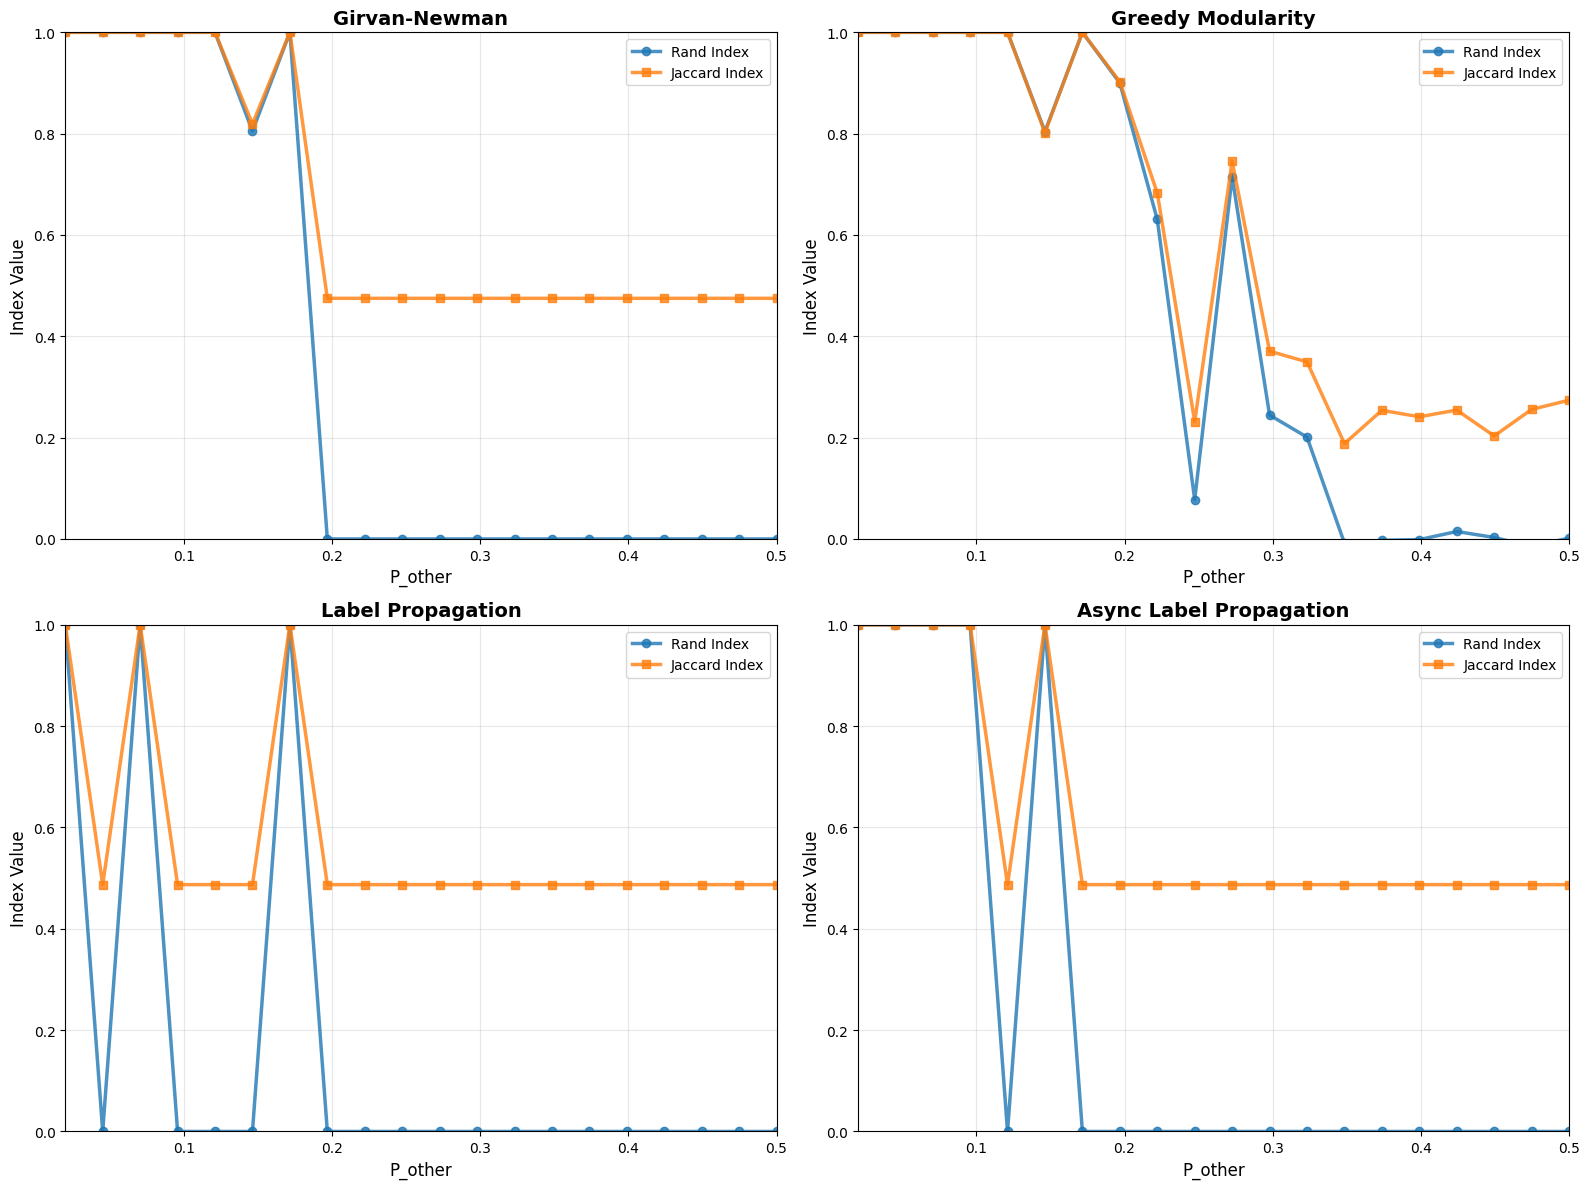

In [102]:
# IMPROVED PLOTTING: Four separate plots, one for each method
print("=== Creating Individual Method Plots ===")

methods = df['Method'].unique()
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

colors = ['#1f77b4', '#ff7f0e']  # Blue for Rand, Orange for Jaccard

for i, method in enumerate(methods):
    method_data = df[df['Method'] == method]
    
    # Plot Rand Index
    axes[i].plot(method_data['P_other'], method_data['Rand_Index'], 
                 marker='o', color=colors[0], label='Rand Index', 
                 linewidth=2.5, markersize=6, alpha=0.8)
    
    # Plot Jaccard Index
    axes[i].plot(method_data['P_other'], method_data['Jaccard_Index'], 
                 marker='s', color=colors[1], label='Jaccard Index', 
                 linewidth=2.5, markersize=6, alpha=0.8)
    
    # Customize each subplot
    axes[i].set_xlabel('P_other', fontsize=12)
    axes[i].set_ylabel('Index Value', fontsize=12)
    axes[i].set_title(f'{method}', fontsize=14, fontweight='bold')
    axes[i].legend(fontsize=10)
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylim(0, 1)
    axes[i].set_xlim(method_data['P_other'].min(), method_data['P_other'].max())

plt.tight_layout()
plt.show()

It appears the Girvan-newman algorithm performs the most consistently well prior to a P_other value of .2. The takeaway I get from this graph (assuming my calculations are accurate) is that no one community generation method is best (at least from the four I choose) - it's worth trying at least 4 different community generation methods and comparing their results when deriving communities from a complex network. 

## Task
 1. Apply at least 4 different community detection methods to the graphs generated by the Stochastic Block Model.
 2. Change the P_other from 0.02 to 0.5 in steps and plot the Rand and Jaccard index score of the different methods as function of P_other
 3. Try the same methods on the second network. Create a matrix of the Rand and Jaccard indices of the different methods (e.g. $J_{ij}$ is the Jaccard index between methods $i$ and $j$)

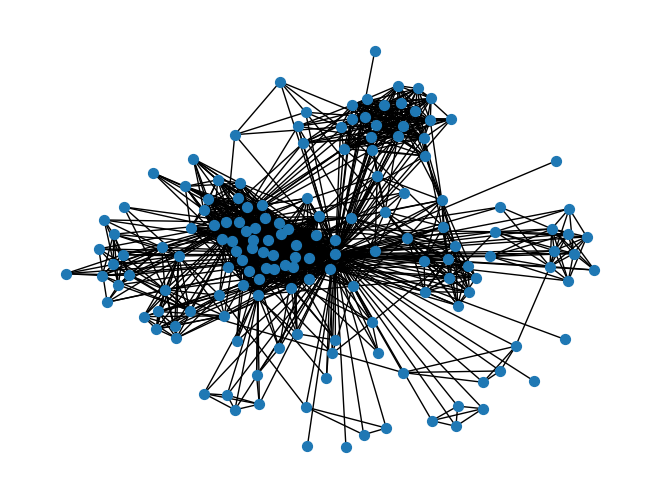

In [106]:
G = nx.Graph(nx.nx_pydot.read_dot('my.dot'))
pos = nx.spring_layout(G,scale=10)
nx.draw(G,pos=pos,node_size=50)

In [ ]:
communities = apply_community_methods(G)
communities.keys()

dict_keys(['Girvan-Newman', 'Greedy Modularity', 'Label Propagation', 'Async Label Propagation'])

In [113]:
# Get the 4 methods
method_names = list(communities.keys())
n_methods = len(method_names)

# Initialize matrices
j_matrix = np.zeros((n_methods, n_methods))
r_matrix = np.zeros((n_methods, n_methods))

# Compare each pair of methods
for i, method_i in enumerate(method_names):
    for j, method_j in enumerate(method_names):
        # Compare communities from method i with communities from method j
        r_idx, j_idx = calculate_metrics_sklearn(
            communities[method_i], 
            communities[method_j]
        )
        r_matrix[i, j] = r_idx
        j_matrix[i, j] = j_idx

# Display the matrices with method names as labels
print("Jaccard Index Matrix:")
print(pd.DataFrame(j_matrix, index=method_names, columns=method_names))
print("\nRand Index Matrix:")
print(pd.DataFrame(r_matrix, index=method_names, columns=method_names))

Jaccard Index Matrix:
                         Girvan-Newman  Greedy Modularity  Label Propagation  \
Girvan-Newman                 1.000000           0.277421           0.987261   
Greedy Modularity             0.277421           1.000000           0.279520   
Label Propagation             0.987261           0.279520           1.000000   
Async Label Propagation       0.239286           0.565313           0.243018   

                         Async Label Propagation  
Girvan-Newman                           0.239286  
Greedy Modularity                       0.565313  
Label Propagation                       0.243018  
Async Label Propagation                 1.000000  

Rand Index Matrix:
                         Girvan-Newman  Greedy Modularity  Label Propagation  \
Girvan-Newman                 1.000000          -0.002375                0.0   
Greedy Modularity            -0.002375           1.000000                0.0   
Label Propagation             0.000000           0.000000     